# X-Ray Image Labelling & Reporting
## Image Captioning
**`Team AKAKI!` | `Minerva University`**

---


**`Goals:`**
- Caption images using computer vision and NLP.
- Test caption similarities to real captions using BLEU score.

This work is inspired by the following [article](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/#:~:text=deep%20learning%20model.-,Defining%20the%20Model,-We%20will%20define)

### 1. Import Libraries

In [ ]:
from tensorflow import keras
from pickle import load
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from numpy import argmax
import nltk
from nltk.corpus import stopwords
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Softmax
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

import itertools

### 2. Import Data

In [ ]:
#Load frontal training set
frontal_train = pd.read_pickle("../data/train/frontal_train.pickle").reset_index(drop=True)

#Specify root directory
root_dir = "/datasets/gdrive/XRay-AKAKI/images_normalized/"

#Load frontal test set
frontal_test = pd.read_pickle('../data/test/frontal_test.pickle').reset_index(drop=True)
#test_descs = frontal_test['caption']

#Randomly select x-ray images for train and testing
train = frontal_train.sample(1000)
test = frontal_test.sample(100)

#Get the filenames (i.e. images)
train_path = train['filename']
test_path = test['filename']

#Get the findings
train_descs = train['findings']
test_descs = test['findings']

### 3. Creating Utility Functions for Modeling

In [ ]:
# Extract features from each photo in the directory
def extract_features(filenames):
    """
    Function to extract the features of the images using VGG16.

    Input(s):
        - filenames: The images to extract features from
    
    Output(s):
        - features: The extracted features from the images

    """
    # load the model
    model = VGG16()

    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # summarize model
    print(model.summary())

    # dictionary to store extracted features from each photo
    features = dict()

    indexes = filenames.index.values

    #Iterate through all the image filenames
    for index, filename in zip(indexes, filenames):

        # load the image from the file
        image = load_img(root_dir+filename, target_size=(224, 224))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        image = preprocess_input(image)

        # get features using the VGG16 model
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = index

        # store extracted feature
        features[image_id] = feature

        print('>%s' % filename)
        
    return features

In [ ]:
def create_tokenizer(descriptions):
    """
    Function to generate tokenizer by fitting on descriptions.
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(descriptions)
    return tokenizer


def to_max_length(lines):
    """
    Function to calculate the length of the descriptions with the most words.
    """
    
    return max(len(d.split()) for d in lines)


def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    """
    Create sequences of images, input sequences and output words for an image
    """

    X1, X2, y = list(), list(), list()

    # walk through each image identifier
    for key, desc_list in descriptions.items():

        # walk through each description for the image
        for desc in desc_list:

            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]

            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):

                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]

                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                # store sequences
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
                
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
## old model

def define_model(vocab_size, max_length):
    """
    Define the captioning model.

    Input(s):
        - vocab_size: The size of the vocabulary (set of unique words)
        - max_length: Maximum sequence length
    
    Output:
        - model: The captioning model

    """

    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
#Getting the length of the longest description
maxx = to_max_length(train_descs)

#Creating the tokenizer
tokenizer = create_tokenizer(train_descs)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

#Extracting the features
train_features = extract_features(train_path)
test_features = extract_features(test_path)
print("Extracted features.")

>2710_IM-1177-1001.dcm.png
>1204_IM-0138-1001.dcm.png
>592_IM-2186-12012.dcm.png
>1762_IM-0497-1001.dcm.png
>2773_IM-1214-1001.dcm.png
>3956_IM-2021-1001.dcm.png
>2611_IM-1102-3001.dcm.png
>3850_IM-1948-1001.dcm.png
>2725_IM-1186-1001.dcm.png
>1157_IM-0106-1001.dcm.png
>1798_IM-0518-1001.dcm.png
>527_IM-2137-1001.dcm.png
>570_IM-2170-1001.dcm.png
>1342_IM-0221-1001.dcm.png
>136_IM-0233-1001.dcm.png
>2592_IM-1084-1001.dcm.png
>2448_IM-0983-1001.dcm.png
>2943_IM-1343-4004.dcm.png
>1024_IM-0019-1001.dcm.png
>3536_IM-1729-4004.dcm.png
>3263_IM-1549-1001.dcm.png
>1883_IM-0572-1001.dcm.png
>847_IM-2369-1001.dcm.png
>2335_IM-0902-2001.dcm.png
>2308_IM-0883-1001.dcm.png
>1902_IM-0586-1001.dcm.png
>929_IM-2427-1001.dcm.png
>1842_IM-0545-1001.dcm.png
>359_IM-1768-1001.dcm.png
>3653_IM-1815-1001.dcm.png
>3458_IM-1678-1001.dcm.png
>3442_IM-1667-1001.dcm.png
>2066_IM-0701-1001.dcm.png
>2306_IM-0882-1001.dcm.png
>1311_IM-0203-1001.dcm.png
>2332_IM-0900-1001.dcm.png
>1322_IM-0208-3003.dcm.png
>3837_I

In [ ]:
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    """
    Create sequences of images, input sequences and output words for an image (this cell may be an issue)
    """

    #Lists to store the sequences
    X1, X2, y = list(), list(), list()

    # walk through each image identifier
    for key, desc_list in descriptions.items():

        # print(f"key: {key}")
        # print(f"value: {desc_list}")
        # walk through each description for the image

        # encode the sequence
        print(f"desc_list: {desc_list}")
        seq = tokenizer.texts_to_sequences([desc_list])[0]

        print(f"seq: {seq}")

        # split one sequence into multiple X,y pairs
        print("length of seq:", len(seq))

        for i in range(1, len(seq)):

            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]

            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=maxx)[0]

            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            # store sequences
            X1.append(photos[key][0])
            #print("photos key: ", photos[key][0])
            X2.append(in_seq)
            print("inseq: ", in_seq)
            y.append(out_seq)
            print("outseq: ", out_seq)
            
    return np.array(X1), np.array(X2), np.array(y)



### 4. Modeling

#### a. Train and fit model

In [ ]:
#prepare training set sequences
X1train, X2train, ytrain = create_sequences(tokenizer, maxx, train_descs, train_features, vocab_size)
print("Created sequences for train.")

# prepare test set sequences
X1test, X2test, ytest = create_sequences(tokenizer, maxx, test_descs, test_features, vocab_size)
print("Created sequences for test.")

FOR LOOP 35
inseq:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 384 420 489 114 356
 341  13 118   5  18   2 209  28   8  20  81 333  17   1  27 100 116  16
  52  17   1  24 100  16 163  24 134 250   6  24]
outseq:  [0. 0. 0. ... 0. 0. 0.]
FOR LOOP 36
inseq:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0 384 420 489 114 356 341
  13 118   5  18   2 209  28   8  20  81 333  17   1  27 100 116  16  52
 

In [ ]:
# define the model
model = define_model(vocab_size, maxx)

# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 120, 256)     270848      input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
# fit model
history = model.fit([X1train, X2train], ytrain, epochs=15, verbose=1, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Epoch 1/15
797/797 [==============================] - 505s 629ms/step - loss: 4.9171 - val_loss: 3.1681

Epoch 00001: val_loss improved from inf to 3.16807, saving model to best_model.h5
Epoch 2/15
797/797 [==============================] - 495s 621ms/step - loss: 2.9716 - val_loss: 2.5080

Epoch 00002: val_loss improved from 3.16807 to 2.50797, saving model to best_model.h5
Epoch 3/15
797/797 [==============================] - 493s 618ms/step - loss: 2.2949 - val_loss: 2.2553

Epoch 00003: val_loss improved from 2.50797 to 2.25532, saving model to best_model.h5
Epoch 4/15
797/797 [==============================] - 494s 620ms/step - loss: 1.8663 - val_loss: 2.1721

Epoch 00004: val_loss improved from 2.25532 to 2.17209, saving model to best_model.h5
Epoch 5/15
797/797 [==============================] - 493s 619ms/step - loss: 1.5955 - val_loss: 2.2055

Epoch 00005: val_loss did not improve from 2.17209
Epoch 6/15
797/797 [==============================] - 492s 618ms/step - loss: 1.3562

#### b. Plot loss over training duration

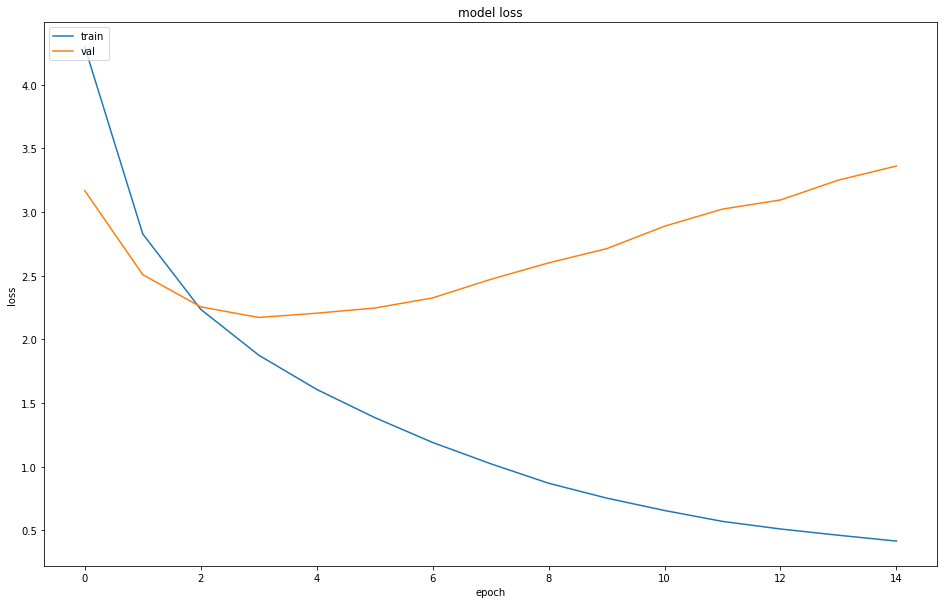

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We see that the training loss drops significantly while the validation loss stays pretty much stagnant. This suggests the model is overfitting the training data

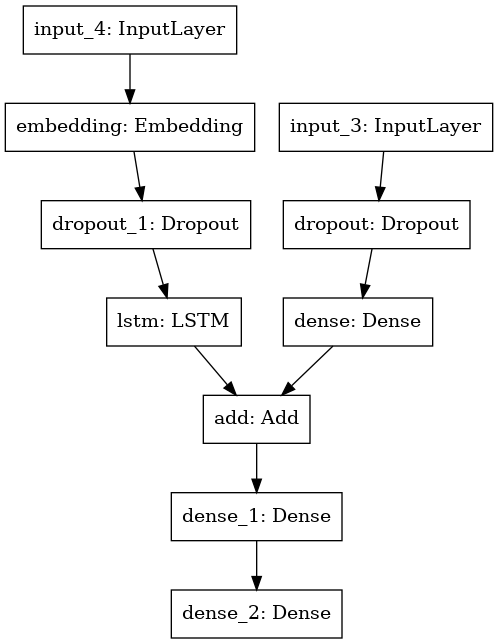

In [ ]:
plot_model(model)

#### c. Generate the text descriptions

In [ ]:
def word_for_id(integer, tokenizer):

	"""
	Map an integer to a word
	"""	

	#Iterate through all the words in the dictionary, getting their unique integer values
	for word, index in tokenizer.word_index.items():

		#If integer we are trying to map to a word, is found in the dictionary
		if index == integer:

			#Return its corresponding word
			return word

	#Else: return None
	return None


def generate_desc(model, tokenizer, photo, max_length):

	"""
	Generate a description for an image
	"""

	in_text = 'Findings:'

	# iterate over the whole length of the sequence
	for i in range(max_length):

		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]

		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)

		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)

		# convert probability to integer
		yhat = argmax(yhat)

		# map integer to word
		word = word_for_id(yhat, tokenizer)

		# stop if we cannot map the word
		if word is None:
			break

		# append as input for generating the next word
		in_text += ' ' + word

		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
			
	return in_text

In [ ]:
# pre-define the max sequence length (from training)
max_length = maxx

train_imgs = list(train_path)
test_imgs = list(test_path)

In [ ]:
def remove_consecutive_duplicates(sentence):

    """
    Function to remove consecutive duplicate words from a sentence
    """
    
    #Split the sentence into words
    word_list = sentence.split(" ")

    #List to store the words after preprocessing
    preprocessed_list = []

    #Group by consecutive unique words and iterate over the grouping
    for x in itertools.groupby(word_list):

        #Add the word to the list
        preprocessed_list.append(x[0])

    return preprocessed_list

In [ ]:
nltk.download("stopwords")
def remove_stop_words(word_list):
    stoppers = stopwords.words('english')
    stoppers.remove('no')
    while (word_list[0] in stoppers) or (word_list[0] == 'startseq'):
        word_list.pop(0)
    while (word_list[-1] in stoppers):
        word_list.pop(-1)
    return " ".join(word_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def clean_sentence(sentence):

    word_list = remove_consecutive_duplicates(sentence)
    sentence = remove_stop_words(word_list)

    return sentence

121
Findings: of focal consolidation pneumothorax or large pleural effusion cardio mediastinal silhouette is unremarkable visualized osseous structures of the thorax areout acute abnormality no acute bony abnormality seen no acute bony abnormality identified there is no pneumothorax or pleural effusion the heart and mediastinum are normal the skeletal structures are normal there are degenerative changes of the spine there is no pneumothorax there is no pneumothorax or pleural effusion the heart and mediastinum are normal the skeletal structures are normal there are degenerative changes of the spine there is no pneumothorax or pleural effusion the lungs are clear the heart size is normal there is no pneumothorax or pleural effusion the lungs are clear the heart size and pulmonary vascularity appearin
121
Findings: of focal consolidation pneumothorax or large pleural effusion cardio mediastinal silhouette is unremarkable visualized osseous structures of the thorax areout acute abnormalit

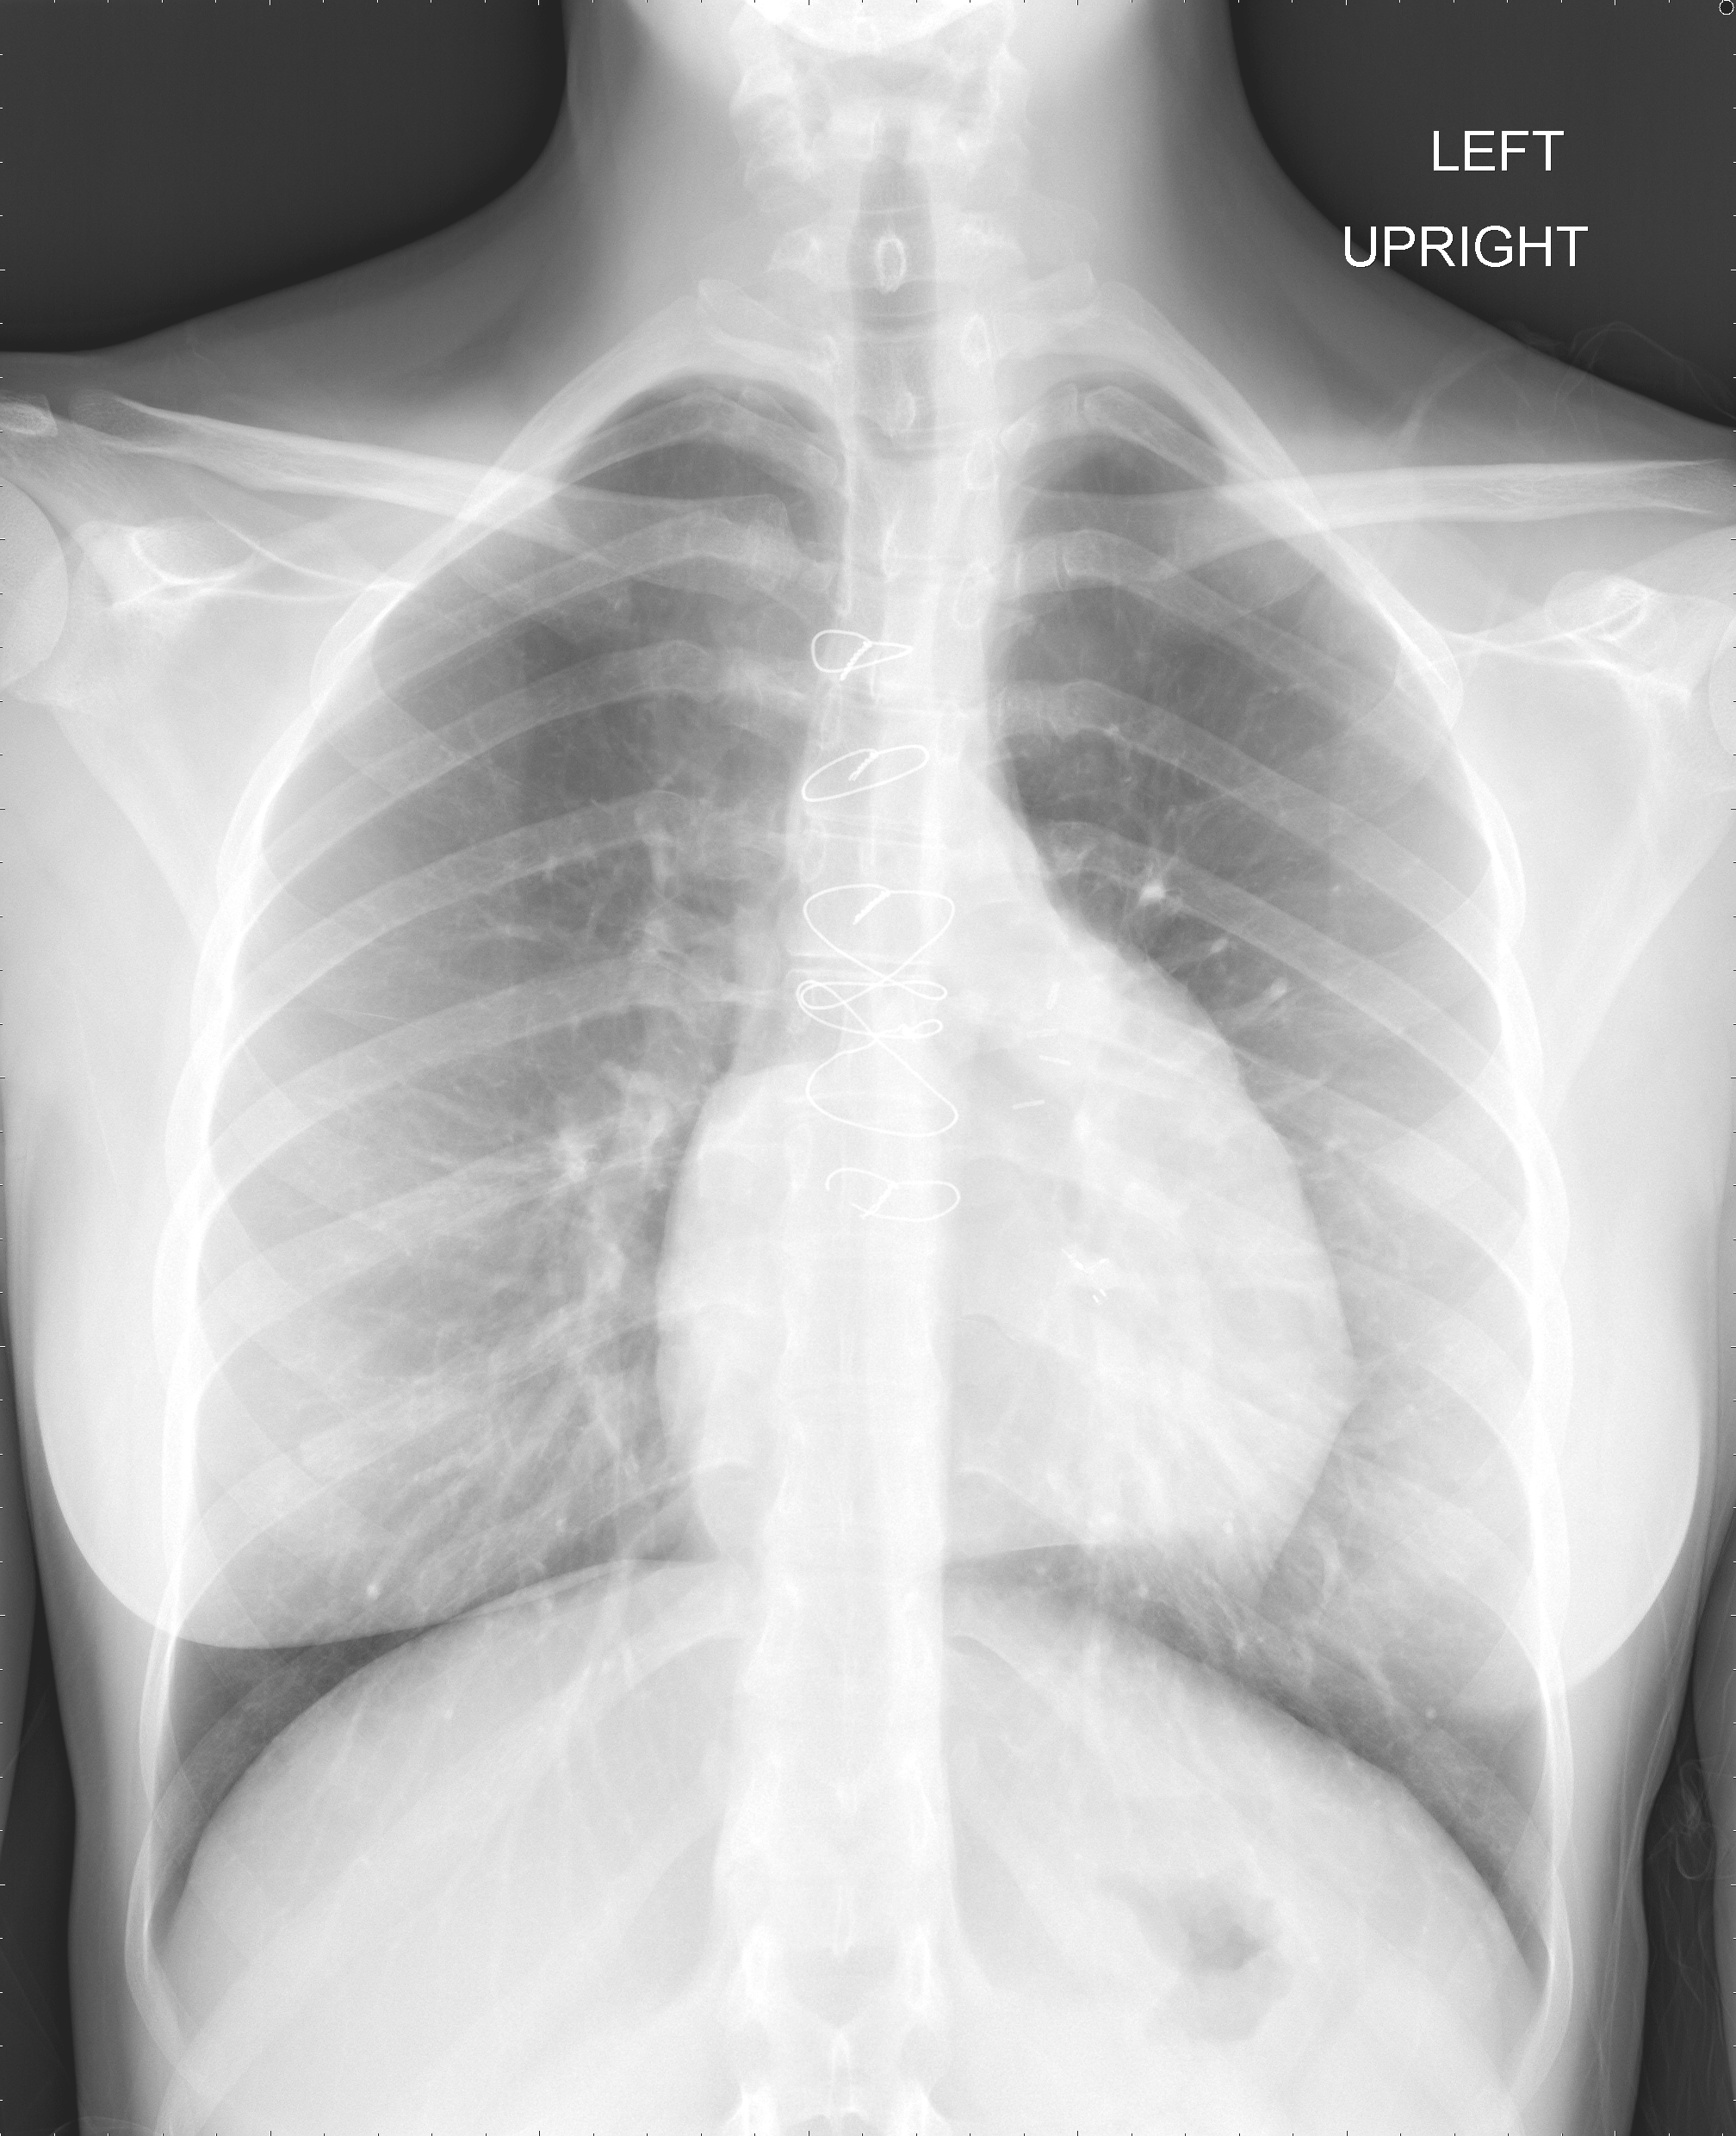

In [ ]:
# load the model using the saved model
saved_model = load_model('best_model.h5')

for i in range(20):
    photo = list(test_features.values())[i]
    description = generate_desc(saved_model, tokenizer, photo, max_length)
    print(remove_consecutive_duplicates(description))
    print(clean_sentence(description))

from PIL import Image
import matplotlib.pyplot as plt

#frontal_train = pd.read_pickle("../data/train/frontal_train.pickle").reset_index(drop=True)

root_dir = "/datasets/gdrive/XRay-AKAKI/images_normalized/"

img = test_imgs[3]

img_path = root_dir + img
image = Image.open(img_path)
image

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu_evaluation(GT_sentences, predicted_sentences):
    BLEU_1 = corpus_bleu(GT_sentences, predicted_sentences, weights=(1.0, 0, 0, 0))
    BLEU_2 = corpus_bleu(GT_sentences, predicted_sentences, weights=(0.5, 0.5, 0, 0))
    BLEU_3 = corpus_bleu(GT_sentences, predicted_sentences, weights=(0.3, 0.3, 0.3, 0))
    BLEU_4 = corpus_bleu(GT_sentences, predicted_sentences, weights=(0.25, 0.25, 0.25, 0.25))
    
    return BLEU_1,BLEU_2,BLEU_3,BLEU_4

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d67d5ca8-f99a-4baf-8748-4aa99efbd09b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>